# Import required libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import cuml
import cudf

from cuml.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

# Import dataframes

In [2]:
# test df analytics
test_df = pd.read_csv("/home/julio-hsu/Desktop/kaggle-competitions/store-sales-prediction/data/training/test.csv")

print("Test DF analytics")
print("-------")
print(test_df.isna().sum())
print("-------")

test_df.head()

Test DF analytics
-------
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
-------


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [3]:
# train df analytics
train_df = pd.read_csv("/home/julio-hsu/Desktop/kaggle-competitions/store-sales-prediction/data/training/train.csv")

print("Train DF analytics")
print("-------")
print(train_df.isna().sum())
print("-------")

train_df.head()

Train DF analytics
-------
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
-------


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


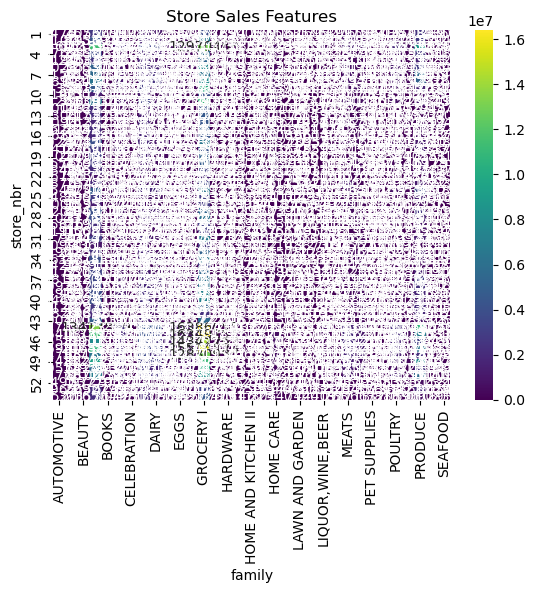

In [4]:
# analyse train dataset features relationship
heatmap_data = train_df.pivot_table(values="sales", index="store_nbr", columns="family", aggfunc="sum")
sns.heatmap(data=heatmap_data, cmap="viridis", annot=True, fmt=".0f")
plt.title("Store Sales Features")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


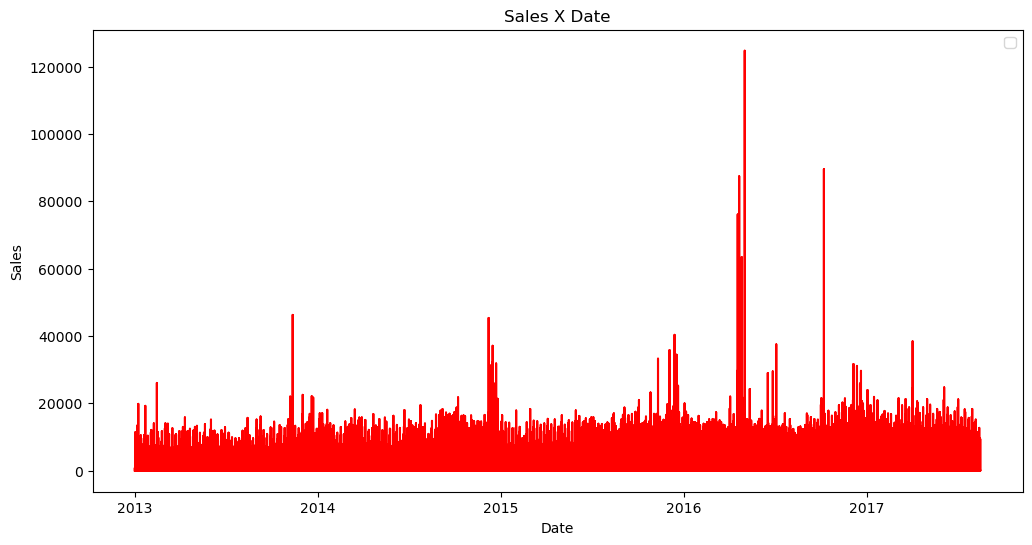

In [5]:
# analyse train dataset sales per date
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] = pd.to_datetime(test_df["date"])

plt.figure(figsize=(12, 6))
plt.plot(train_df["date"], train_df["sales"], color="red")
plt.title("Sales X Date")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [6]:
# holidays df analytics
holidays_df = pd.read_csv("/home/julio-hsu/Desktop/kaggle-competitions/store-sales-prediction/data/training/features/date/holidays_events.csv")

print("Holidays DF analytics")
print("-------")
print(holidays_df.isna().sum())
print("-------")

holidays_df.head()

Holidays DF analytics
-------
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
-------


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
# enhance holidays features
holidays_df["holiday_area"] = holidays_df["locale_name"] + "_" + holidays_df["locale"] + "_" + holidays_df["type"]
holidays_df["holiday_transferred"] = holidays_df["transferred"]

# holidays_df_area = holidays_df[["locale_name", "locale"]].drop_duplicates()
# holidays_df_area = holidays_df_area.rename(columns={"locale_name": "city", "locale": "region_type"})

holidays_df = holidays_df.drop(columns=["type", "locale", "description", "transferred"])
holidays_df = holidays_df.rename(columns={"locale_name": "city"})

holidays_df.head()

,date,city,holiday_area,holiday_transferred
0,2012-03-02,Manta,Manta_Local_Holiday,False
1,2012-04-01,Cotopaxi,Cotopaxi_Regional_Holiday,False
2,2012-04-12,Cuenca,Cuenca_Local_Holiday,False
3,2012-04-14,Libertad,Libertad_Local_Holiday,False
4,2012-04-21,Riobamba,Riobamba_Local_Holiday,False


In [8]:
# oil df analytics
oil_df = pd.read_csv("/home/julio-hsu/Desktop/kaggle-competitions/store-sales-prediction/data/training/features/date/oil.csv")

print("Oil DF analytics")
print("-------")
print(oil_df.isna().sum())
print("-------")
print("Correcting oil_df erros...")

# correct nan error
for i, price in enumerate(oil_df["dcoilwtico"]):
    if i == 0 & np.isnan(price):
        oil_df.loc[i, "dcoilwtico"] = oil_df.loc[i+1, "dcoilwtico"]
    elif i == -1 & np.isnan(price):
        oil_df.loc[i, "dcoilwtico"] = oil_df.loc[i-1, "dcoilwtico"]
    elif np.isnan(price):
        oil_df.loc[i, "dcoilwtico"] = oil_df.loc[i-1, "dcoilwtico"]
    else:
        continue

oil_df.head()


Oil DF analytics
-------
date           0
dcoilwtico    43
dtype: int64
-------
Correcting oil_df erros...


,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [9]:
# enhance oil features
oil_df["oil_inflation"] = oil_df["dcoilwtico"] - oil_df["dcoilwtico"].shift(1)
oil_df.loc[0, "oil_inflation"] = 0

oil_df

,date,dcoilwtico,oil_inflation
0,2013-01-01,93.14,0.00
1,2013-01-02,93.14,0.00
2,2013-01-03,92.97,-0.17
3,2013-01-04,93.12,0.15
4,2013-01-07,93.20,0.08
...,...,...,...
1213,2017-08-25,47.65,0.41
1214,2017-08-28,46.40,-1.25
1215,2017-08-29,46.46,0.06
1216,2017-08-30,45.96,-0.50


In [10]:
# stores df analytics
stores_df = pd.read_csv("/home/julio-hsu/Desktop/kaggle-competitions/store-sales-prediction/data/training/features/store_nbr/stores.csv")

print("Stores DF analytics")
print("-------")
print(stores_df.isna().sum())
print("-------")

stores_df.head()

Stores DF analytics
-------
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
-------


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
# enhance stores features
state_region_map = {
    'Pichincha': 'Sierra (Andes)',
    'Cotopaxi': 'Sierra (Andes)',
    'Chimborazo': 'Sierra (Andes)',
    'Imbabura': 'Sierra (Andes)',
    'Santo Domingo de los Tsachilas': 'Sierra (Andes)',
    'Bolivar': 'Sierra (Andes)',
    'Pastaza': 'Amazonía (Amazon)',
    'Tungurahua': 'Sierra (Andes)',
    'Guayas': 'Costa (Coast)',
    'Santa Elena': 'Costa (Coast)',
    'Los Rios': 'Costa (Coast)',
    'Azuay': 'Sierra (Andes)',
    'Loja': 'Sierra (Andes)',
    'El Oro': 'Costa (Coast)',
    'Esmeraldas': 'Costa (Coast)',
    'Manabi': 'Costa (Coast)'
}
stores_df["region"] = stores_df["state"].map(state_region_map)

stores_df.head()

,store_nbr,city,state,type,cluster,region
0,1,Quito,Pichincha,D,13,Sierra (Andes)
1,2,Quito,Pichincha,D,13,Sierra (Andes)
2,3,Quito,Pichincha,D,8,Sierra (Andes)
3,4,Quito,Pichincha,D,9,Sierra (Andes)
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,Sierra (Andes)


In [12]:
# extract features
train_df_id = pd.DataFrame(train_df.pop(item="id"))
train_df_date = pd.DataFrame(train_df.pop(item="date"))
train_df_sales = pd.DataFrame(train_df.pop(item="sales"))
train_df_onpromotion = pd.DataFrame(train_df.pop(item="onpromotion"))

test_df_id = pd.DataFrame(test_df.pop("id"))
test_df_date = pd.DataFrame(test_df.pop("date"))
test_df_onpromotion = pd.DataFrame(test_df.pop("onpromotion"))

train_df.head()

,store_nbr,family
0,1,AUTOMOTIVE
1,1,BABY CARE
2,1,BEAUTY
3,1,BEVERAGES
4,1,BOOKS


In [13]:
# merge store features
train_df = pd.merge(train_df, stores_df, on="store_nbr", how="left")
test_df = pd.merge(test_df, stores_df, on="store_nbr", how="left")

train_df.head()

,store_nbr,family,city,state,type,cluster,region
0,1,AUTOMOTIVE,Quito,Pichincha,D,13,Sierra (Andes)
1,1,BABY CARE,Quito,Pichincha,D,13,Sierra (Andes)
2,1,BEAUTY,Quito,Pichincha,D,13,Sierra (Andes)
3,1,BEVERAGES,Quito,Pichincha,D,13,Sierra (Andes)
4,1,BOOKS,Quito,Pichincha,D,13,Sierra (Andes)


In [14]:
# date features
train_df["date"] = pd.to_datetime(train_df_date["date"])

# year features
train_df["year"] = train_df["date"].dt.year

# month features
train_df["month_of_year"] = train_df["date"].dt.month
train_df["month_of_year_sin"] = np.sin(2 * np.pi * train_df["month_of_year"] / 12)
train_df["month_of_year_cos"] = np.cos(2 * np.pi * train_df["month_of_year"] / 12)

# week features
train_df["week_of_year"] = train_df["date"].dt.isocalendar().week

# day features
train_df["day_of_year"] = train_df["date"].dt.dayofyear

train_df["day_of_month"] = train_df["date"].dt.day

train_df["day_of_week"] = train_df["date"].dt.dayofweek
train_df["day_of_week_sin"] = np.sin(2 * np.pi * train_df["day_of_week"] / 7)
train_df["day_of_week_cos"] = np.cos(2 * np.pi * train_df["day_of_week"] / 7)

train_df["day_of_weekend"] = train_df["day_of_week"].isin([5 ,6]).astype(int)

train_df.shape

(3000888, 19)

In [15]:
# date features
test_df["date"] = pd.to_datetime(test_df_date["date"])

# year features
test_df["year"] = test_df["date"].dt.year

# month features
test_df["month_of_year"] = test_df["date"].dt.month
test_df["month_of_year_sin"] = np.sin(2 * np.pi * test_df["month_of_year"] / 12)
test_df["month_of_year_cos"] = np.cos(2 * np.pi * test_df["month_of_year"] / 12)

# week features
test_df["week_of_year"] = test_df["date"].dt.isocalendar().week

# day features
test_df["day_of_year"] = test_df["date"].dt.dayofyear

test_df["day_of_month"] = test_df["date"].dt.day

test_df["day_of_week"] = test_df["date"].dt.dayofweek
test_df["day_of_week_sin"] = np.sin(2 * np.pi * test_df["day_of_week"] / 7)
test_df["day_of_week_cos"] = np.cos(2 * np.pi * test_df["day_of_week"] / 7)

test_df["day_of_weekend"] = test_df["day_of_week"].isin([5 ,6]).astype(int)

test_df.shape

(28512, 19)

In [16]:
# merge holidays features
# holidays_df["date"] = pd.to_datetime(holidays_df["date"])

# train_df = pd.merge(train_df, holidays_df, on=["date"], how="left").drop_duplicates()
# train_df = train_df.fillna({"holiday_area": "no_holiday", "holiday_transferred": "no_holiday"})

# train_df.shape

In [17]:
# check for the difference shape of dataframes
# diff = train_df.compare(train_df2)

# diff

In [18]:
# merge oil features
oil_df["date"] = pd.to_datetime(oil_df["date"])

train_df = pd.merge(train_df, oil_df, on="date", how="left")
train_df["dcoilwtico"] = train_df["dcoilwtico"].ffill()
train_df["oil_inflation"] = train_df["oil_inflation"].fillna(0.0)

test_df = pd.merge(test_df, oil_df, on="date", how="left")
test_df["dcoilwtico"] = test_df["dcoilwtico"].ffill()
test_df["oil_inflation"] = test_df["oil_inflation"].fillna(0.0)

train_df.head()

,store_nbr,family,city,state,type,cluster,region,date,year,month_of_year,...,month_of_year_cos,week_of_year,day_of_year,day_of_month,day_of_week,day_of_week_sin,day_of_week_cos,day_of_weekend,dcoilwtico,oil_inflation
0,1,AUTOMOTIVE,Quito,Pichincha,D,13,Sierra (Andes),2013-01-01,2013,1,...,0.866025,1,1,1,1,0.781831,0.62349,0,93.14,0.0
1,1,BABY CARE,Quito,Pichincha,D,13,Sierra (Andes),2013-01-01,2013,1,...,0.866025,1,1,1,1,0.781831,0.62349,0,93.14,0.0
2,1,BEAUTY,Quito,Pichincha,D,13,Sierra (Andes),2013-01-01,2013,1,...,0.866025,1,1,1,1,0.781831,0.62349,0,93.14,0.0
3,1,BEVERAGES,Quito,Pichincha,D,13,Sierra (Andes),2013-01-01,2013,1,...,0.866025,1,1,1,1,0.781831,0.62349,0,93.14,0.0
4,1,BOOKS,Quito,Pichincha,D,13,Sierra (Andes),2013-01-01,2013,1,...,0.866025,1,1,1,1,0.781831,0.62349,0,93.14,0.0


In [19]:
# merge back onpromotion and sales features
train_df["onpromotion"] = train_df_onpromotion
train_df["sales"] = train_df_sales

test_df["onpromotion"] = test_df_onpromotion

train_df.head()

,store_nbr,family,city,state,type,cluster,region,date,year,month_of_year,...,day_of_year,day_of_month,day_of_week,day_of_week_sin,day_of_week_cos,day_of_weekend,dcoilwtico,oil_inflation,onpromotion,sales
0,1,AUTOMOTIVE,Quito,Pichincha,D,13,Sierra (Andes),2013-01-01,2013,1,...,1,1,1,0.781831,0.62349,0,93.14,0.0,0,0.0
1,1,BABY CARE,Quito,Pichincha,D,13,Sierra (Andes),2013-01-01,2013,1,...,1,1,1,0.781831,0.62349,0,93.14,0.0,0,0.0
2,1,BEAUTY,Quito,Pichincha,D,13,Sierra (Andes),2013-01-01,2013,1,...,1,1,1,0.781831,0.62349,0,93.14,0.0,0,0.0
3,1,BEVERAGES,Quito,Pichincha,D,13,Sierra (Andes),2013-01-01,2013,1,...,1,1,1,0.781831,0.62349,0,93.14,0.0,0,0.0
4,1,BOOKS,Quito,Pichincha,D,13,Sierra (Andes),2013-01-01,2013,1,...,1,1,1,0.781831,0.62349,0,93.14,0.0,0,0.0


In [20]:
# convert categorical data into numerical data
def convert_categ(X):
    label = LabelEncoder()
    columns = ["family", "city", "state", "type", "region"]
    for col in columns:
        X[col] = label.fit_transform(X[col])
        
convert_categ(train_df)
convert_categ(test_df)

train_df

,store_nbr,family,city,state,type,cluster,region,date,year,month_of_year,...,day_of_year,day_of_month,day_of_week,day_of_week_sin,day_of_week_cos,day_of_weekend,dcoilwtico,oil_inflation,onpromotion,sales
0,1,0,18,12,3,13,2,2013-01-01,2013,1,...,1,1,1,0.781831,0.62349,0,93.14,0.00,0,0.000
1,1,1,18,12,3,13,2,2013-01-01,2013,1,...,1,1,1,0.781831,0.62349,0,93.14,0.00,0,0.000
2,1,2,18,12,3,13,2,2013-01-01,2013,1,...,1,1,1,0.781831,0.62349,0,93.14,0.00,0,0.000
3,1,3,18,12,3,13,2,2013-01-01,2013,1,...,1,1,1,0.781831,0.62349,0,93.14,0.00,0,0.000
4,1,4,18,12,3,13,2,2013-01-01,2013,1,...,1,1,1,0.781831,0.62349,0,93.14,0.00,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,9,28,18,12,1,6,2,2017-08-15,2017,8,...,227,15,1,0.781831,0.62349,0,47.57,-0.02,0,438.133
3000884,9,29,18,12,1,6,2,2017-08-15,2017,8,...,227,15,1,0.781831,0.62349,0,47.57,-0.02,1,154.553
3000885,9,30,18,12,1,6,2,2017-08-15,2017,8,...,227,15,1,0.781831,0.62349,0,47.57,-0.02,148,2419.729
3000886,9,31,18,12,1,6,2,2017-08-15,2017,8,...,227,15,1,0.781831,0.62349,0,47.57,-0.02,8,121.000


In [21]:
test_df

,store_nbr,family,city,state,type,cluster,region,date,year,month_of_year,...,week_of_year,day_of_year,day_of_month,day_of_week,day_of_week_sin,day_of_week_cos,day_of_weekend,dcoilwtico,oil_inflation,onpromotion
0,1,0,18,12,3,13,2,2017-08-16,2017,8,...,33,228,16,2,0.974928,-0.222521,0,46.80,-0.77,0
1,1,1,18,12,3,13,2,2017-08-16,2017,8,...,33,228,16,2,0.974928,-0.222521,0,46.80,-0.77,0
2,1,2,18,12,3,13,2,2017-08-16,2017,8,...,33,228,16,2,0.974928,-0.222521,0,46.80,-0.77,2
3,1,3,18,12,3,13,2,2017-08-16,2017,8,...,33,228,16,2,0.974928,-0.222521,0,46.80,-0.77,20
4,1,4,18,12,3,13,2,2017-08-16,2017,8,...,33,228,16,2,0.974928,-0.222521,0,46.80,-0.77,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,9,28,18,12,1,6,2,2017-08-31,2017,8,...,35,243,31,3,0.433884,-0.900969,0,47.26,1.30,1
28508,9,29,18,12,1,6,2,2017-08-31,2017,8,...,35,243,31,3,0.433884,-0.900969,0,47.26,1.30,0
28509,9,30,18,12,1,6,2,2017-08-31,2017,8,...,35,243,31,3,0.433884,-0.900969,0,47.26,1.30,1
28510,9,31,18,12,1,6,2,2017-08-31,2017,8,...,35,243,31,3,0.433884,-0.900969,0,47.26,1.30,9


# Train model

In [22]:
# split dataset for train and valuate
y = train_df.pop("sales")

X = train_df.drop(columns=["date"])
X_test = test_df.drop(columns=["date"])

X

,store_nbr,family,city,state,type,cluster,region,year,month_of_year,month_of_year_sin,...,week_of_year,day_of_year,day_of_month,day_of_week,day_of_week_sin,day_of_week_cos,day_of_weekend,dcoilwtico,oil_inflation,onpromotion
0,1,0,18,12,3,13,2,2013,1,0.500000,...,1,1,1,1,0.781831,0.62349,0,93.14,0.00,0
1,1,1,18,12,3,13,2,2013,1,0.500000,...,1,1,1,1,0.781831,0.62349,0,93.14,0.00,0
2,1,2,18,12,3,13,2,2013,1,0.500000,...,1,1,1,1,0.781831,0.62349,0,93.14,0.00,0
3,1,3,18,12,3,13,2,2013,1,0.500000,...,1,1,1,1,0.781831,0.62349,0,93.14,0.00,0
4,1,4,18,12,3,13,2,2013,1,0.500000,...,1,1,1,1,0.781831,0.62349,0,93.14,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,9,28,18,12,1,6,2,2017,8,-0.866025,...,33,227,15,1,0.781831,0.62349,0,47.57,-0.02,0
3000884,9,29,18,12,1,6,2,2017,8,-0.866025,...,33,227,15,1,0.781831,0.62349,0,47.57,-0.02,1
3000885,9,30,18,12,1,6,2,2017,8,-0.866025,...,33,227,15,1,0.781831,0.62349,0,47.57,-0.02,148
3000886,9,31,18,12,1,6,2,2017,8,-0.866025,...,33,227,15,1,0.781831,0.62349,0,47.57,-0.02,8


In [23]:
# split train and val dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_gpu = cudf.DataFrame.from_pandas(X_train)
y_train_gpu = cudf.Series(y_train)

X_val_gpu = cudf.DataFrame.from_pandas(X_val)
y_val_gpu = cudf.Series(y_val)

X_test_gpu = cudf.DataFrame.from_pandas(X_test)

X_train_gpu

,store_nbr,family,city,state,type,cluster,region,year,month_of_year,month_of_year_sin,...,week_of_year,day_of_year,day_of_month,day_of_week,day_of_week_sin,day_of_week_cos,day_of_weekend,dcoilwtico,oil_inflation,onpromotion
2902383,45,0,18,12,0,11,2,2017,6,1.224647e-16,...,25,172,21,2,0.974928,-0.222521,0,42.48,-0.86,2
1651514,47,29,18,12,0,14,2,2015,7,-5.000000e-01,...,29,199,18,5,-0.974928,-0.222521,1,50.88,0.00,0
1948349,26,29,8,6,3,10,1,2016,1,5.000000e-01,...,53,2,2,5,-0.974928,-0.222521,1,37.13,0.00,0
2893871,7,2,18,12,3,8,2,2017,6,1.224647e-16,...,24,167,16,4,-0.433884,-0.900969,0,44.73,0.26,1
2867501,16,32,21,14,2,3,2,2017,6,1.224647e-16,...,22,153,2,4,-0.433884,-0.900969,0,47.68,-0.64,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692743,54,8,5,10,2,3,1,2015,8,-8.660254e-01,...,33,222,10,0,0.000000,1.000000,0,44.94,1.07,0
2356330,23,31,0,15,3,9,2,2016,8,-8.660254e-01,...,33,231,18,3,0.433884,-0.900969,0,48.20,1.39,0
2229084,53,0,14,10,3,13,1,2016,6,1.224647e-16,...,23,159,7,1,0.781831,0.623490,0,50.37,0.66,0
2768307,33,3,17,9,2,3,1,2017,4,8.660254e-01,...,14,97,7,4,-0.433884,-0.900969,0,52.25,0.56,15


In [24]:
# train model
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train_gpu, y_train_gpu)

/home/julio-hsu/anaconda3/lib/python3.8/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/julio-hsu/anaconda3/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RandomForestRegressor()

In [25]:
# val model
y_pred = model.predict(X_val_gpu)
rmsle_loss = mean_squared_log_error(y_val_gpu.to_numpy(), y_pred.to_numpy())
print(f"rmsle loss: {rmsle_loss}")

rmsle loss: 2.0073221925282656


In [32]:
# test submission
sample_submission_df = pd.read_csv("/home/julio-hsu/Desktop/kaggle-competitions/store-sales-prediction/data/submission/sample_submission.csv")

y_test = model.predict(X_test_gpu)

sample_submission_df.drop(columns=["sales"])
sample_submission_df["sales"] = y_test.to_numpy()

sample_submission_df

,id,sales
0,3000888,4.676330
1,3000889,0.246946
2,3000890,8.169503
3,3000891,2285.313611
4,3000892,0.142218
...,...,...
28507,3029395,515.594479
28508,3029396,172.162935
28509,3029397,895.178101
28510,3029398,663.584591


In [33]:
sample_submission_df.to_csv("./data/submission/test.csv", index=False)